## Libraries

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy


## Exploratory Analysis

In [49]:
df = pd.read_csv("train.csv", index_col = 0)

In [50]:
df.shape

(80176, 13)

In [51]:
df.columns

Index(['date', 'org', 'tld', 'ccs', 'bcced', 'mail_type', 'images', 'urls',
       'salutations', 'designation', 'chars_in_subject', 'chars_in_body',
       'label'],
      dtype='object')

In [52]:
df.head()

,date,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,chars_in_subject,chars_in_body,label
0,"Mon, 6 Nov 2017 11:13:45 +0100",reply,ebay.in,0,0,multipart/alternative,35,120,0,0,49.0,80027,2
1,"Wed, 14 Feb 2018 11:00:16 -0000",edm,efinmail.com,0,0,multipart/alternative,1,7,0,0,107.0,2961,1
2,"Wed, 6 Jul 2016 19:53:37 +0000",usebackpack,com,0,0,text/html,4,17,0,0,35.0,25149,1
3,"Fri, 11 Oct 2019 11:25:40 +0200",granular,ai,0,0,multipart/mixed,0,0,0,0,15.0,635296,1
4,"Tue, 07 Nov 2017 11:07:18 +0000 (UTC)",github,com,1,0,multipart/alternative,2,11,0,0,49.0,2355,1


In [53]:
df.dtypes

date                 object
org                  object
tld                  object
ccs                   int64
bcced                 int64
mail_type            object
images                int64
urls                  int64
salutations           int64
designation           int64
chars_in_subject    float64
chars_in_body         int64
label                 int64
dtype: object

## Data Cleaning

#### Cleaning Date

In [54]:
def get_day(x):
    days = ['Mon', 'Wed', 'Fri', 'Tue', 'Sun', 'Sat', 'Thu']
    if x.split(' ')[0][:-1] in days:
        return x.split(' ')[0][:-1]
    return 'No day'
df['day'] = df['date'].apply(get_day)

def get_day_number(x):
    try:
        day_number = int(x.split(' ')[1])
        return day_number
    except:
        try:
            day_number = int(x.split(' ')[0][:-1])
            return day_number
        except:
            return -1
        
def get_month(x):
    months = ['Aug', 'Sep', 'Oct', 'Jul', 'Apr', 'Mar', 'Jan', 'Jun', 'Feb', 'May', 'Nov', 'Dec']
    try:
        if x.split(' ')[2] in months:
            return x.split(' ')[2]
        elif x.split(' ')[1] in months:
            return x.split(' ')[1]
    except:
        return 'No Month' 
    
def get_year(x):
    try:
        year = int(x.split(' ')[3])
        return year
    except:
        try: 
            year = int(x.split(' ')[2])
            if year > 2000:
                return year
            else:
                try:
                    year = int(x.split(' ')[1])
                    if year > 2000:
                        return year
                except:
                    return 0
        except:
            return 0
def get_hour(x):
    try:
        hour = int(x.split(' ')[4][:2])
        return hour
    except:
        return -1

In [55]:
df['day'] = df['date'].apply(get_day)
df['day_number'] = df['date'].apply(get_day_number)
df['month'] = df['date'].apply(get_month)
df['year'] = df['date'].apply(get_year)
df['hour'] = df['date'].apply(get_hour)

#### Cleaning ORG

In [56]:
def get_top_org(min_count = 1000):
    """Gets the mininum occurence number of an organization and 
    returns the organizations which occur more than the minimu

    Parameters
    ----------
    The minimum number of occurence for an organization
    min_count : int 

    Returns
    -------
    All the organizatinos occuring more than the minimum
    list_org : list
    """
    (df.org.value_counts() > min_count).value_counts()
    df_temp = df.groupby(['org']).count()
    df_temp[df_temp['date'] > min_count].shape
    df_temp[df_temp['date'] > min_count]['date'].sum()
    list_org = list(df_temp[df_temp['date'] > min_count].index)
    return list_org

org_list = get_top_org()

def new_org_column(x):
    global org_list
    if x in org_list:
        return x
    else:
        return 'Others'


We can see that 7 org accounts for more than half the count, this could be a parameter

In [57]:
df['top_org'] = df['org'].apply(new_org_column)

In [58]:
df['top_org']

0             Others
1             Others
2        usebackpack
3             Others
4             github
            ...     
80171         github
80172         Others
80173         google
80174         Others
80175         Others
Name: top_org, Length: 80176, dtype: object

#### clean TLD

In [59]:
def get_top_tld(min_count = 1000):
    """Gets the mininum occurence number of an organization and 
    returns the organizations which occur more than the minimuù

    Parameters
    ----------
    The minimum number of occurence for an organization
    min_count : int 

    Returns
    -------
    All the organizatinos occuring more than the minimum
    list_org : list
    """
    (df.tld.value_counts() > min_count).value_counts()
    df_temp = df.groupby(['tld']).count()
    df_temp[df_temp['date'] > min_count].shape
    df_temp[df_temp['date'] > min_count]['date'].sum()
    list_tld = list(df_temp[df_temp['date'] > min_count].index)
    return list_tld

org_list = get_top_tld(500)

def new_tld_column(x):
    global org_list
    if x in org_list:
        return x
    else:
        return 'Others'


In [60]:
df['top_tld'] = df['tld'].apply(new_tld_column)

In [61]:
df['top_tld'].value_counts()

top_tld
com            34619
ac.in          20042
Others         12576
in              3783
org             3428
fr              1580
gov.in          1540
ai               720
co.in            704
netflix.com      629
net              555
Name: count, dtype: int64

#### Clean Mail

In [62]:
df.mail_type.unique()

array(['multipart/alternative', 'text/html', 'multipart/mixed',
       'multipart/related', 'text/plain', nan, 'text/html ',
       'multipart/signed', 'Multipart/Mixed', 'Text/Html',
       'multipart/report', 'Multipart/Alternative', 'text/calendar',
       'multipart/IDM'], dtype=object)

In [63]:
def get_mail_type1(x):
    try:
        mails = x.split('/')
        mail = mails[0].lower()
        return mail
    except:
        return 'other'

def get_mail_type2(x):
    try:
        mails = x.split('/')
        mail = mails[1].lower()
        return mail
    except:
        return 'other'

In [64]:
df['mail1'] = df.mail_type.apply(get_mail_type1)
df['mail2'] = df.mail_type.apply(get_mail_type2)

In [65]:
df['mail1'].value_counts()
df['mail2'].value_counts()

mail2
alternative    58452
html           10234
mixed           6500
plain           2720
related         1996
other            172
html              58
signed            26
report            13
calendar           4
idm                1
Name: count, dtype: int64

#### Cleaning Missing values

In [66]:
df.describe()

,ccs,bcced,images,urls,salutations,designation,chars_in_subject,chars_in_body,label,day_number,year,hour
count,80176.000000,80176.000000,80176.000000,80176.000000,80176.000000,80176.000000,80160.000000,8.017600e+04,80176.000000,80176.000000,80176.000000,80176.000000
mean,0.473259,0.002869,7.875998,34.433172,0.406381,0.104246,51.535254,1.971784e+05,1.557187,14.891676,2002.465451,11.328951
std,3.178805,0.053484,305.444093,97.904682,0.491160,0.305581,33.718283,1.890130e+06,1.713352,9.080254,169.903425,6.238051
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000e+00,0.000000,-1.000000,0.000000,-1.000000
25%,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,32.000000,4.651000e+03,1.000000,7.000000,2016.000000,7.000000
50%,0.000000,0.000000,2.000000,17.000000,0.000000,0.000000,42.000000,1.999950e+04,1.000000,14.000000,2017.000000,12.000000
75%,0.000000,0.000000,8.000000,44.000000,1.000000,0.000000,62.000000,4.519300e+04,2.000000,23.000000,2018.000000,16.000000
max,179.000000,1.000000,83481.000000,21540.000000,1.000000,1.000000,606.000000,7.438108e+07,7.000000,31.000000,2020.000000,23.000000


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80176 entries, 0 to 80175
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              80176 non-null  object 
 1   org               76725 non-null  object 
 2   tld               76723 non-null  object 
 3   ccs               80176 non-null  int64  
 4   bcced             80176 non-null  int64  
 5   mail_type         80004 non-null  object 
 6   images            80176 non-null  int64  
 7   urls              80176 non-null  int64  
 8   salutations       80176 non-null  int64  
 9   designation       80176 non-null  int64  
 10  chars_in_subject  80160 non-null  float64
 11  chars_in_body     80176 non-null  int64  
 12  label             80176 non-null  int64  
 13  day               80176 non-null  object 
 14  day_number        80176 non-null  int64  
 15  month             79606 non-null  object 
 16  year              80176 non-null  int64  
 17

#### Cleaning MONTH

In [68]:
df.loc[df.month.isna(), 'month'] = 'Missing'

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80176 entries, 0 to 80175
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              80176 non-null  object 
 1   org               76725 non-null  object 
 2   tld               76723 non-null  object 
 3   ccs               80176 non-null  int64  
 4   bcced             80176 non-null  int64  
 5   mail_type         80004 non-null  object 
 6   images            80176 non-null  int64  
 7   urls              80176 non-null  int64  
 8   salutations       80176 non-null  int64  
 9   designation       80176 non-null  int64  
 10  chars_in_subject  80160 non-null  float64
 11  chars_in_body     80176 non-null  int64  
 12  label             80176 non-null  int64  
 13  day               80176 non-null  object 
 14  day_number        80176 non-null  int64  
 15  month             80176 non-null  object 
 16  year              80176 non-null  int64  
 17

#### CHARS in subject

In [70]:
df.loc[df.chars_in_subject.isna(), 'chars_in_subject'] = -1

In [71]:
df['has_subject'] = (df['chars_in_subject'] > 0).astype(int)

#### Remove the unnecessary columns

In [72]:
df = df.drop(['date','org','tld','mail_type'], axis = 1)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80176 entries, 0 to 80175
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ccs               80176 non-null  int64  
 1   bcced             80176 non-null  int64  
 2   images            80176 non-null  int64  
 3   urls              80176 non-null  int64  
 4   salutations       80176 non-null  int64  
 5   designation       80176 non-null  int64  
 6   chars_in_subject  80176 non-null  float64
 7   chars_in_body     80176 non-null  int64  
 8   label             80176 non-null  int64  
 9   day               80176 non-null  object 
 10  day_number        80176 non-null  int64  
 11  month             80176 non-null  object 
 12  year              80176 non-null  int64  
 13  hour              80176 non-null  int64  
 14  top_org           80176 non-null  object 
 15  top_tld           80176 non-null  object 
 16  mail1             80176 non-null  object 
 17

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80176 entries, 0 to 80175
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ccs               80176 non-null  int64  
 1   bcced             80176 non-null  int64  
 2   images            80176 non-null  int64  
 3   urls              80176 non-null  int64  
 4   salutations       80176 non-null  int64  
 5   designation       80176 non-null  int64  
 6   chars_in_subject  80176 non-null  float64
 7   chars_in_body     80176 non-null  int64  
 8   label             80176 non-null  int64  
 9   day               80176 non-null  object 
 10  day_number        80176 non-null  int64  
 11  month             80176 non-null  object 
 12  year              80176 non-null  int64  
 13  hour              80176 non-null  int64  
 14  top_org           80176 non-null  object 
 15  top_tld           80176 non-null  object 
 16  mail1             80176 non-null  object 
 17

In [75]:
object_columns = df.select_dtypes(include=['object']).columns

# One-hot encode object columns
df_encoded = pd.get_dummies(df, columns=object_columns)

# Display the encoded DataFrame
print(df_encoded.head())

   ccs  bcced  images  urls  salutations  designation  chars_in_subject  \
0    0      0      35   120            0            0              49.0   
1    0      0       1     7            0            0             107.0   
2    0      0       4    17            0            0              35.0   
3    0      0       0     0            0            0              15.0   
4    1      0       2    11            0            0              49.0   

   chars_in_body  label  day_number  ...  mail2_calendar  mail2_html  \
0          80027      2           6  ...           False       False   
1           2961      1          14  ...           False       False   
2          25149      1           6  ...           False        True   
3         635296      1          11  ...           False       False   
4           2355      1           7  ...           False       False   

   mail2_html   mail2_idm  mail2_mixed  mail2_other  mail2_plain  \
0        False      False        False        Fa

In [76]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80176 entries, 0 to 80175
Data columns (total 72 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ccs                  80176 non-null  int64  
 1   bcced                80176 non-null  int64  
 2   images               80176 non-null  int64  
 3   urls                 80176 non-null  int64  
 4   salutations          80176 non-null  int64  
 5   designation          80176 non-null  int64  
 6   chars_in_subject     80176 non-null  float64
 7   chars_in_body        80176 non-null  int64  
 8   label                80176 non-null  int64  
 9   day_number           80176 non-null  int64  
 10  year                 80176 non-null  int64  
 11  hour                 80176 non-null  int64  
 12  has_subject          80176 non-null  int64  
 13  day_Fri              80176 non-null  bool   
 14  day_Mon              80176 non-null  bool   
 15  day_No day           80176 non-null  bool

## Modeling

#### Apply logistic regression

In [77]:
columns_to_apply = ['ccs','images','salutations','chars_in_subject', 'urls', 'chars_in_body','day_number','year','hour']

Explanation

(array([8.0111e+04, 2.0000e+01, 9.0000e+00, 2.0000e+00, 9.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 2.3000e+01, 1.0000e+00]),
 array([  0. ,  17.9,  35.8,  53.7,  71.6,  89.5, 107.4, 125.3, 143.2,
        161.1, 179. ]),
 <BarContainer object of 10 artists>)

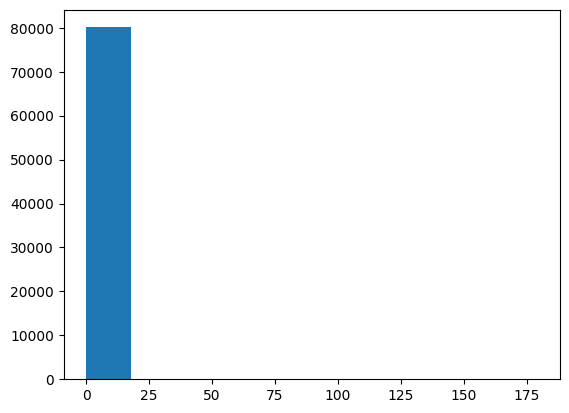

In [78]:
plt.hist(df['ccs'])

(array([6.7283e+04, 5.3640e+03, 5.0090e+03, 1.7610e+03, 5.5800e+02,
        1.5100e+02, 5.0000e+00, 9.0000e+00, 1.2000e+01, 2.4000e+01]),
 array([0.        , 0.51929569, 1.03859137, 1.55788706, 2.07718274,
        2.59647843, 3.11577411, 3.6350698 , 4.15436548, 4.67366117,
        5.19295685]),
 <BarContainer object of 10 artists>)

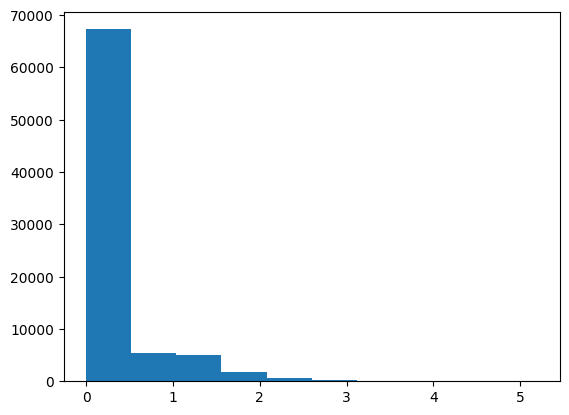

In [79]:
plt.hist(np.log(df['ccs'] + 1))

In [80]:
for column in columns_to_apply:
    df_encoded[column] = np.log(df_encoded[column] + 3)

In [81]:
df_encoded.describe()

,ccs,bcced,images,urls,salutations,designation,chars_in_subject,chars_in_body,label,day_number,year,hour,has_subject
count,80176.000000,80176.000000,80176.000000,80176.000000,80176.000000,80176.000000,80176.000000,80176.000000,80176.000000,80176.000000,80176.000000,80176.000000,80176.000000
mean,1.189882,0.002869,1.851521,2.915175,1.215521,0.104246,3.833130,9.524993,1.557187,2.713350,7.564252,2.531137,0.993564
std,0.254638,0.053484,0.818691,1.220684,0.141298,0.305581,0.598760,2.108542,1.713352,0.641947,0.548564,0.567579,0.079966
min,1.098612,0.000000,1.098612,1.098612,1.098612,0.000000,0.693147,1.945910,0.000000,0.693147,1.098612,0.693147,0.000000
25%,1.098612,0.000000,1.098612,1.945910,1.098612,0.000000,3.555348,8.445482,1.000000,2.302585,7.610358,2.302585,1.000000
50%,1.098612,0.000000,1.609438,2.995732,1.098612,0.000000,3.806662,9.903613,1.000000,2.833213,7.610853,2.708050,1.000000
75%,1.098612,0.000000,2.397895,3.850148,1.386294,0.000000,4.174387,10.718764,2.000000,3.258097,7.611348,2.944439,1.000000
max,5.204007,1.000000,11.332410,9.977806,1.386294,1.000000,6.411818,18.124712,7.000000,3.526361,7.612337,3.258097,1.000000


#### Standardize

In [82]:
""" df_standardize = df_encoded.copy()
df_standardize.drop['']
df_standardize.info()
columns_to_standardize = list(df_standardize.columns)
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the selected columns
df_standardize[columns_to_standardize] = scaler.fit_transform(df_standardize[columns_to_standardize])
df_standardize.describe() """

" df_standardize = df_encoded.copy()\ndf_standardize.drop['']\ndf_standardize.info()\ncolumns_to_standardize = list(df_standardize.columns)\nfrom sklearn.preprocessing import StandardScaler\n\n# Initialize StandardScaler\nscaler = StandardScaler()\n\n# Fit and transform the selected columns\ndf_standardize[columns_to_standardize] = scaler.fit_transform(df_standardize[columns_to_standardize])\ndf_standardize.describe() "

In [83]:
df_encoded

,ccs,bcced,images,urls,salutations,designation,chars_in_subject,chars_in_body,label,day_number,...,mail2_calendar,mail2_html,mail2_html,mail2_idm,mail2_mixed,mail2_other,mail2_plain,mail2_related,mail2_report,mail2_signed
0,1.098612,0,3.637586,4.812184,1.098612,0,3.951244,11.290157,2,2.197225,...,False,False,False,False,False,False,False,False,False,False
1,1.098612,0,1.386294,2.302585,1.098612,0,4.700480,7.994295,1,2.833213,...,False,False,False,False,False,False,False,False,False,False
2,1.098612,0,1.945910,2.995732,1.098612,0,3.637586,10.132693,1,2.197225,...,False,True,False,False,False,False,False,False,False,False
3,1.098612,0,1.098612,1.098612,1.098612,0,2.890372,13.361851,1,2.639057,...,False,False,False,False,True,False,False,False,False,False
4,1.386294,0,1.609438,2.639057,1.098612,0,3.951244,7.765569,1,2.302585,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80171,1.386294,0,1.098612,2.397895,1.098612,0,4.543295,7.177782,3,3.496508,...,False,False,False,False,False,False,False,False,False,False
80172,1.098612,0,1.098612,1.609438,1.386294,0,4.330733,9.507998,0,0.693147,...,False,True,False,False,False,False,False,False,False,False
80173,1.098612,0,3.401197,4.477337,1.098612,0,3.891820,10.257238,0,3.367296,...,False,False,False,False,False,False,False,False,False,False
80174,1.098612,0,3.555348,5.488938,1.386294,1,5.147494,11.564369,0,2.833213,...,False,False,False,False,False,False,False,False,False,False


### Train and Test split

In [84]:
# Used for deep learning after because it doesn't want a type string
deep_df = df_encoded.copy()

### Stop here for Deep learning

In [38]:
df_encoded['label'] = df_encoded['label'].values.astype('str')

In [39]:

# Assuming X contains your features and y contains your target variable
X = df_encoded.drop(columns=['label'])  # Features (excluding the target variable)
y = df_encoded['label']  # Target variable

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Modeling

In [40]:
y_train.unique()

array(['0', '1', '2', '3', '7', '5', '4', '6'], dtype=object)

In [41]:

# Assuming X_train, X_test, y_train, y_test are already defined from the train-test split
# Initialize logistic regression model
logistic_regression_model = LogisticRegression(max_iter = 1000)

# Train the model
logistic_regression_model.fit(X_train, y_train)

# Predict on the test data
y_pred = logistic_regression_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
accuracy

0.5361062609129459

In [43]:
classification_report(y_test, y_pred)

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       0.55      0.36      0.43      3680\n           1       0.53      0.66      0.59      7429\n           2       0.43      0.32      0.36      1719\n           3       0.59      0.51      0.55      2109\n           4       0.40      0.04      0.07        50\n           5       0.00      0.00      0.00        26\n           6       0.00      0.00      0.00        31\n           7       0.57      0.76      0.65       992\n\n    accuracy                           0.54     16036\n   macro avg       0.38      0.33      0.33     16036\nweighted avg       0.53      0.54      0.52     16036\n'

In [44]:
cm = confusion_matrix(y_test, y_pred)

In [45]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logistic_regression_model.classes_)

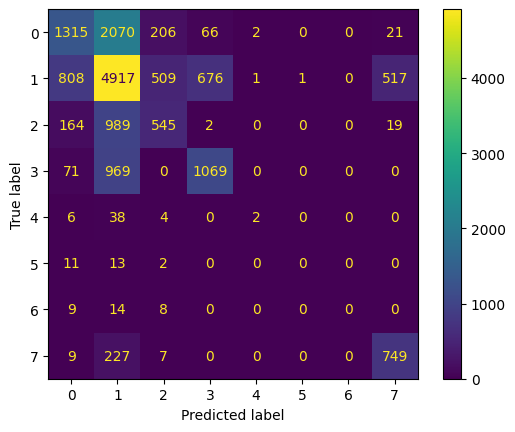

In [46]:
disp.plot()

In [47]:
scores = cross_val_score(logistic_regression_model, X_train, y_train, cv=5, scoring='f1_macro')

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

KeyboardInterrupt: 

In [ ]:
scores

array([0.32790782, 0.32604786, 0.3318429 , 0.32401763, 0.32536912])

In [ ]:
y_train.value_counts()

label
1    29766
0    14315
3     8618
2     6848
7     4050
4      307
6      121
5      115
Name: count, dtype: int64

### Dealing with Imbalanced data

#### Oversampling

In [ ]:
oversample = RandomOverSampler()
X_over, y_over = oversample.fit_resample(X, y)
y_over.value_counts()

label
2    37195
1    37195
3    37195
7    37195
0    37195
4    37195
6    37195
5    37195
Name: count, dtype: int64

In [ ]:
def oversample_logistic(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Assuming X_train, X_test, y_train, y_test are already defined from the train-test split
    # Initialize logistic regression model
    logistic_regression_model = LogisticRegression(max_iter = 1000)

    # Train the model
    logistic_regression_model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = logistic_regression_model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logistic_regression_model.classes_)

    disp.plot()

    return y_pred, y_test

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


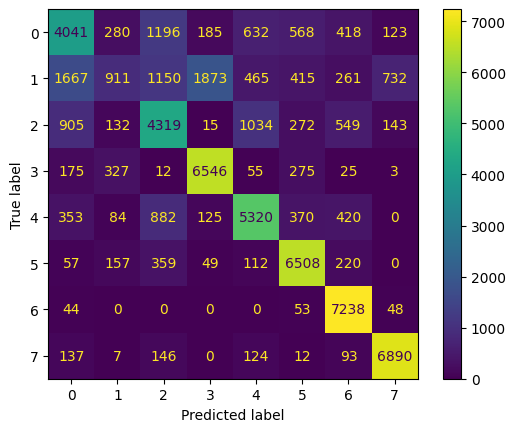

In [ ]:
y_pred, y_test = oversample_logistic(X_over,y_over)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print('accuracy : ' + str(accuracy))
f1_score = f1_score(y_test, y_pred, average='weighted')
print('f1 score  : ' + str(f1_score))

accuracy : 0.701925662051351
f1 score  : 0.6732111031343394


### No Sampling

#### Trying different Models

In [ ]:

# Define a dictionary to store models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC()
}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {name}: {accuracy:.4f}")
    
    # Additional evaluation metrics
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))
    
    print(f"Confusion Matrix for {name}:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")


    # Extract F1 score from classification report
    f1_score = classification_rep.split()[-2]

    print("F1 Score:", f1_score)



Training Logistic Regression...


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy for Logistic Regression: 0.5293
Classification Report for Logistic Regression:


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.55      0.36      0.44      3680
           1       0.53      0.66      0.59      7429
           2       0.42      0.35      0.38      1719
           3       0.58      0.52      0.55      2109
           4       0.00      0.00      0.00        50
           5       0.00      0.00      0.00        26
           6       0.00      0.00      0.00        31
           7       0.56      0.54      0.55       992

    accuracy                           0.53     16036
   macro avg       0.33      0.30      0.31     16036
weighted avg       0.53      0.53      0.52     16036

Confusion Matrix for Logistic Regression:
[[1338 2031  232   61    0    0    0   18]
 [ 816 4919  593  714    0    1    0  386]
 [ 202  894  607    3    0    0    0   13]
 [  22  994    0 1093    0    0    0    0]
 [   6   37    7    0    0    0    0    0]
 [   9   13    4    0    0    0    0    0]
 [   7   16    8    0    0    0    0    0]
 [  14

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df_encoded['label'].value_counts()

label
1    37195
0    17995
3    10727
2     8567
7     5042
4      357
6      152
5      141
Name: count, dtype: int64

In [ ]:
def oversample_multi_models(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define a dictionary to store models
    models = {
        'Logistic Regression': LogisticRegression(),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Support Vector Machine': SVC()
    }

    # Train and evaluate each model
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logistic_regression_model.classes_)

        accuracy = accuracy_score(y_test, y_pred)
        print('accuracy : ' + str(accuracy))
        f1_value = f1_score(y_test, y_pred, average='weighted')
        print('f1 score  : ' + str(f1_value))

        disp.plot()

In [ ]:
y_pred, y_test = oversample_multi_models(X_over,y_over)

Training Logistic Regression...


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy : 0.6864497916386612
f1 score  : 0.6631368996488407
Training Decision Tree...
accuracy : 0.8783102567549402
f1 score  : 0.8639599064071858
Training Random Forest...
accuracy : 0.8813012501680333
f1 score  : 0.8658276140795483
Training Support Vector Machine...


### Using Deep Learning Algorithms

In [85]:
deep_df = df_encoded.copy()

### No Sampling

In [86]:
bool_columns = deep_df.select_dtypes(include=['bool']).columns

In [87]:
deep_df[bool_columns] = deep_df[bool_columns].astype(int)

In [88]:
"""
one_hot_encoded = pd.get_dummies(deep_df['label'], prefix='class')
one_hot_encoded
"""

"\none_hot_encoded = pd.get_dummies(deep_df['label'], prefix='class')\none_hot_encoded\n"

In [89]:
X2 = deep_df.drop(columns=['label']) 
y2 = deep_df['label']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)


In [90]:
Xtensor = tf.convert_to_tensor(X_train2)
ytensor = tf.convert_to_tensor(y_train2)

Define

In [91]:
model = Sequential(
    [
        Dense(15, activation='relu', name = 'layer1'),
        Dense(13, activation='relu', name = 'layer2'),
        Dense(11, activation='relu', name = 'layer3'),
        Dense(8, activation='linear') 
     ]
)

Not Preferred

In [92]:
"""
model = Sequential(
    [
        Dense(15, activation='relu', name = 'layer1'),
        Dense(13, activation='relu', name = 'layer2'),
        Dense(11, activation='relu', name = 'layer3'),
        Dense(8, activation='softmax') 
     ]
)
"""

"\nmodel = Sequential(\n    [\n        Dense(15, activation='relu', name = 'layer1'),\n        Dense(13, activation='relu', name = 'layer2'),\n        Dense(11, activation='relu', name = 'layer3'),\n        Dense(8, activation='softmax') \n     ]\n)\n"

Compile

In [93]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [94]:
"""
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
)
"""

'\nmodel.compile(\n    loss = tf.keras.losses.BinaryCrossentropy(),\n    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)\n)\n'

Fit

In [95]:
model.fit(
    Xtensor,ytensor,            
    epochs=10,
)

Epoch 1/10
2005/2005 [==============================] - 1s 423us/step - loss: 1.0733
Epoch 2/10
2005/2005 [==============================] - 1s 462us/step - loss: 0.9434
Epoch 3/10
2005/2005 [==============================] - 1s 469us/step - loss: 0.9177
Epoch 4/10
2005/2005 [==============================] - 1s 403us/step - loss: 0.9050
Epoch 5/10
2005/2005 [==============================] - 1s 414us/step - loss: 0.8975
Epoch 6/10
2005/2005 [==============================] - 1s 421us/step - loss: 0.8912
Epoch 7/10
2005/2005 [==============================] - 1s 409us/step - loss: 0.8873
Epoch 8/10
2005/2005 [==============================] - 1s 405us/step - loss: 0.8839
Epoch 9/10
2005/2005 [==============================] - 1s 464us/step - loss: 0.8813
Epoch 10/10
2005/2005 [==============================] - 1s 417us/step - loss: 0.8795


In [96]:
loss = model.evaluate(Xtensor, ytensor, verbose=0)
loss

0.8774704337120056

In [97]:
#Xtensor = tf.convert_to_tensor(X_train2)
#ytensor = tf.convert_to_tensor(y_train2)
yhat = model.predict(X_train2)

2005/2005 [==============================] - 1s 318us/step


In [98]:
# Convert one-hot encoded arrays back to class labels
y_true = y_train2 # Convert one-hot encoded y to class labels
y_pred = yhat.argmax(axis=1)  # Convert one-hot encoded y_hat to class labels

# Generate classification report
report = classification_report(y_true, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.61      0.34      0.43     14315
           1       0.53      0.72      0.61     29766
           2       0.49      0.27      0.35      6848
           3       0.65      0.44      0.53      8618
           4       0.00      0.00      0.00       307
           5       0.00      0.00      0.00       115
           6       0.00      0.00      0.00       121
           7       0.57      0.78      0.66      4050

    accuracy                           0.55     64140
   macro avg       0.36      0.32      0.32     64140
weighted avg       0.56      0.55      0.53     64140



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Remember that the dataset is quite inbalanced

In [99]:
y2.value_counts()

label
1    37195
0    17995
3    10727
2     8567
7     5042
4      357
6      152
5      141
Name: count, dtype: int64

### Using oversampling

In [100]:
oversample = RandomOverSampler()

In [101]:
X2 = deep_df.drop(columns=['label']) 
y2 = deep_df['label']

In [102]:
X_over, y_over = oversample.fit_resample(X2, y2)
y_over.value_counts()

label
2    37195
1    37195
3    37195
7    37195
0    37195
4    37195
6    37195
5    37195
Name: count, dtype: int64

In [103]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_over, y_over, test_size=0.2, random_state=42)


In [104]:
Xtensor = tf.convert_to_tensor(X_train2)
ytensor = tf.convert_to_tensor(y_train2)

In [105]:
model = Sequential(
    [
        Dense(15, activation='relu', name = 'layer1'),
        Dense(13, activation='relu', name = 'layer2'),
        Dense(11, activation='relu', name = 'layer3'),
        Dense(20, activation='relu', name = 'layer4'),
        Dense(15, activation='relu', name = 'layer5'),
        Dense(8, activation='linear')
     ]
)

In [106]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [107]:
model.fit(
    Xtensor,ytensor,            
    epochs=50,
)

Epoch 1/50
7439/7439 [==============================] - 4s 487us/step - loss: 0.9642
Epoch 2/50
7439/7439 [==============================] - 4s 495us/step - loss: 0.7787
Epoch 3/50
7439/7439 [==============================] - 4s 501us/step - loss: 0.7285
Epoch 4/50
7439/7439 [==============================] - 4s 522us/step - loss: 0.6991
Epoch 5/50
7439/7439 [==============================] - 4s 507us/step - loss: 0.6808
Epoch 6/50
7439/7439 [==============================] - 4s 488us/step - loss: 0.6686
Epoch 7/50
7439/7439 [==============================] - 4s 535us/step - loss: 0.6575
Epoch 8/50
7439/7439 [==============================] - 4s 545us/step - loss: 0.6462
Epoch 9/50
7439/7439 [==============================] - 4s 495us/step - loss: 0.6396
Epoch 10/50
7439/7439 [==============================] - 4s 516us/step - loss: 0.6325
Epoch 11/50
7439/7439 [==============================] - 4s 471us/step - loss: 0.6249
Epoch 12/50
7439/7439 [==============================] - 4s 545

In [108]:
loss = model.evaluate(Xtensor, ytensor, verbose=0)
loss

0.5344462394714355

In [109]:
yhat = model.predict(X_train2)

7439/7439 [==============================] - 3s 402us/step


In [110]:
# Convert one-hot encoded arrays back to class labels
y_true = y_train2 # Convert one-hot encoded y to class labels
y_pred = yhat.argmax(axis=1)  # Convert one-hot encoded y_hat to class labels

# Generate classification report
report = classification_report(y_true, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.59      0.65      0.62     29752
           1       0.60      0.15      0.24     29721
           2       0.63      0.76      0.69     29826
           3       0.78      0.92      0.84     29777
           4       0.88      0.98      0.93     29641
           5       0.98      1.00      0.99     29733
           6       0.96      1.00      0.98     29812
           7       0.88      0.94      0.91     29786

    accuracy                           0.80    238048
   macro avg       0.79      0.80      0.77    238048
weighted avg       0.79      0.80      0.77    238048



In [111]:
yhat = model.predict(X_test2)

1860/1860 [==============================] - 1s 296us/step


In [112]:
# Convert one-hot encoded arrays back to class labels
y_true = y_test2  # Convert one-hot encoded y to class labels
y_pred = yhat.argmax(axis=1)  # Convert one-hot encoded y_hat to class labels

# Generate classification report
report = classification_report(y_true, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.59      0.66      0.62      7443
           1       0.58      0.15      0.23      7474
           2       0.63      0.76      0.69      7369
           3       0.78      0.92      0.84      7418
           4       0.88      0.99      0.93      7554
           5       0.97      1.00      0.99      7462
           6       0.96      1.00      0.98      7383
           7       0.88      0.94      0.91      7409

    accuracy                           0.80     59512
   macro avg       0.78      0.80      0.77     59512
weighted avg       0.78      0.80      0.77     59512



Using Cross validation to select the models

In [123]:
X_train_BC, X_, y_train_BC, y_= train_test_split(X_over, y_over, test_size=0.2, random_state=42)
X_val_CV, X_test_CV, y_val_CV, y_test_CV= train_test_split(X_, y_, test_size=0.5, random_state=42)


In [140]:
model1 = Sequential(
    [
        Dense(15, activation='relu', name = 'layer1'),
        Dense(13, activation='relu', name = 'layer2'),
        Dense(11, activation='relu', name = 'layer3'),
        Dense(20, activation='relu', name = 'layer4'),
        Dense(15, activation='relu', name = 'layer5'),
        Dense(8, activation='linear')
     ]
)

model2 = Sequential(
    [
        Dense(15, activation='relu', name = 'layer1'),
        Dense(13, activation='relu', name = 'layer2'),
        Dense(20, activation='relu', name = 'layer3'),
        Dense(8, activation='linear')
     ]
)

model3 = Sequential(
    [
        Dense(15, activation='relu', name = 'layer1'),
        Dense(20, activation='relu', name = 'layer2'),
        Dense(35, activation='relu', name = 'layer3'),
        Dense(23, activation='relu', name = 'layer4'),
        Dense(31, activation='relu', name = 'layer5'),
        Dense(20, activation='relu', name = 'layer6'),
        Dense(15, activation='relu', name = 'layer7'),
        Dense(8, activation='linear')
     ]
)

In [141]:
# Initialize lists that will contain the errors for each model
nn_train_error = []
nn_cv_error = []

# Build the models
models_bc = [model1, model2, model3]

# Loop over each model
for model in models_bc:
    
    # Setup the loss and optimizer
    model.compile(
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    )

    print(f"Training {model.name}...")

    # Train the model
    model.fit(
        Xtensor,ytensor,            
        epochs=10,
        verbose=0
    )
    
    # Record the fraction of misclassified examples for the training set
    yhat = model.predict(X_train_BC)

    y_true = y_train_BC # Convert one-hot encoded y to class labels
    y_pred = yhat.argmax(axis=1)  # Convert one-hot encoded y_hat to class labels

    f1modelscore = f1_score(y_true, y_pred, average = 'weighted')
    
    nn_train_error.append(f1modelscore)

    # Record the fraction of misclassified examples for the training set
    yhat = model.predict(X_val_CV)

    y_true = y_val_CV # Convert one-hot encoded y to class labels
    y_pred = yhat.argmax(axis=1)  # Convert one-hot encoded y_hat to class labels

    f1modelscore = f1_score(y_true, y_pred, average = 'weighted')

    nn_cv_error.append(f1modelscore)


# Print the result
for model_num in range(len(nn_train_error)):
    print(
        f"Model {model_num+1}: Training Set Classification Error: {nn_train_error[model_num]:.5f}, " +
        f"CV Set Classification Error: {nn_cv_error[model_num]:.5f}"
        )

Training sequential_15...
930/930 [==============================] - 0s 332us/step


Training sequential_16...
930/930 [==============================] - 0s 293us/step


Training sequential_17...
930/930 [==============================] - 0s 314us/step
Model 1: Training Set Classification Error: 0.76537, CV Set Classification Error: 0.76241
Model 2: Training Set Classification Error: 0.77604, CV Set Classification Error: 0.77532
Model 3: Training Set Classification Error: 0.79195, CV Set Classification Error: 0.78849


### Selecting the best perfoming model

In [127]:
# Select the model with the lowest error
model_num = 2

# Compute the test error
yhat = models_bc[model_num-1].predict(X_test_CV)
y_true = y_test_CV 
y_pred = yhat.argmax(axis=1) 
f1modelscore = f1_score(y_true, y_pred, average = 'weighted')


print(f"Selected Model: {model_num}")
print(f"Training Set Classification Error: {nn_train_error[model_num-1]:.4f}")
print(f"CV Set Classification Error: {nn_cv_error[model_num-1]:.4f}")
print(f"Test Set Classification Error: {f1modelscore:.4f}")

930/930 [==============================] - 0s 421us/step
Selected Model: 2
Training Set Classification Error: 0.7472
CV Set Classification Error: 0.7475
Test Set Classification Error: 0.7467


Adding Learning Curves

In [128]:
from sklearn.model_selection import learning_curve

In [130]:
?learning_curve

Signature:
learning_curve(
    estimator,
    X,
    y,
    *,
    groups=None,
    train_sizes=array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
    cv=None,
    scoring=None,
    exploit_incremental_learning=False,
    n_jobs=None,
    pre_dispatch='all',
    verbose=0,
    shuffle=False,
    random_state=None,
    error_score=nan,
    return_times=False,
    fit_params=None,
)
Docstring:
Learning curve.

Determines cross-validated training and test scores for different training
set sizes.

A cross-validation generator splits the whole dataset k times in training
and test data. Subsets of the training set with varying sizes will be used
to train the estimator and a score for each training subset size and the
test set will be computed. Afterwards, the scores will be averaged over
all k runs for each training subset size.

Read more in the :ref:`User Guide <learning_curve>`.

Parameters
----------
estimator : object type that implements the "fit" method
    An object of that type which is cl

In [134]:
model1 = Sequential(
    [
        Dense(15, activation='relu', name = 'layer1'),
        Dense(13, activation='relu', name = 'layer2'),
        Dense(11, activation='relu', name = 'layer3'),
        Dense(20, activation='relu', name = 'layer4'),
        Dense(15, activation='relu', name = 'layer5'),
        Dense(8, activation='linear')
     ]
)
model1.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [135]:
train_size_abs, train_scores, test_scores = learning_curve(
    model1, Xtensor, ytensor, train_sizes=[0.3, 0.6, 0.9], cv = 5)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.src.engine.sequential.Sequential object at 0x29801dc50> does not.